In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_2d, circmean
from load import load_online
import unif_space_utils as usu
from tqdm import tqdm
from prev_resp import model_plot
from von_mises_causal_inf import VonMisesCausalInference
import pickle

['fe0b183d8918b2030aa99a0_', '81ccd016c73180001fa5b2a_', 'e8c8d000bec2302d2fe6986_', '01eccdff4c4d4364966f25d_', '101a6fa67adbc588f881300_', 'ec3fd47a9b68d287e6d7990_', 'f6fb3e1e5d748575a2cff99_', '2718143dbf8c13a6c3fe3e2_', '94abd98215cbd000146debc_', 'da486f989f3800015f5a4d3_', '936d77cebf54a0001566901_', 'b54b7ae2680970001a9a7d3_', 'f784d0ac0c40e3ca59f3d71_', '0bb404e01d599dfb1c3d71c_', 'e37453bf269746d9e616f34_', '1150ec9ff89021c26dcd061_', 'ea0e078e106cc0e69e55f18_', '1448dfe5ec18d063d315875_', 'db09b3a9611830016dd495b_', '11163c821ec0815f38cd241_', '109a7f3a7bda990dfb5ce00_', 'd826545e3ab4b00183cd4e5_', '10d8a3d1aaa591cbe6c4ceb_', 'e722d54811ec3046b5defbd_', '1037333eaacd23a3460ffc2_', 'e4da2248f2be10718acf61b_', '23499c1de37d4c70abc20e7_', '9feed1da383a100011b3eaa_', 'e11ff6f814bba8816cca900_', 'aad68f74ea21d000101c20c_', '00ca855f894621c7d38f30b_', '9cc44f13306be000195beca_', '1094758045acf6530a8b403_', 'd542c3a5af5900019bc80c4_', '03c124974df2e8f9f375fa8_', 'd1e0b068777b50001f

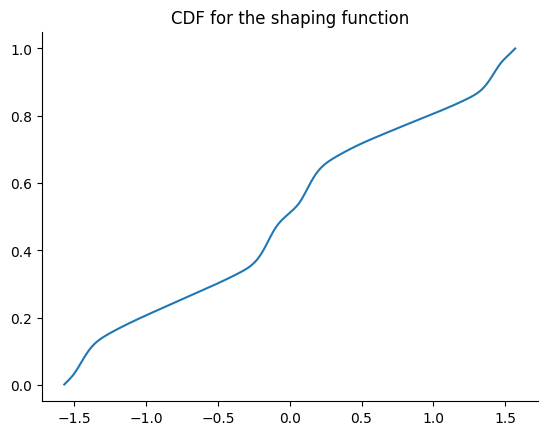

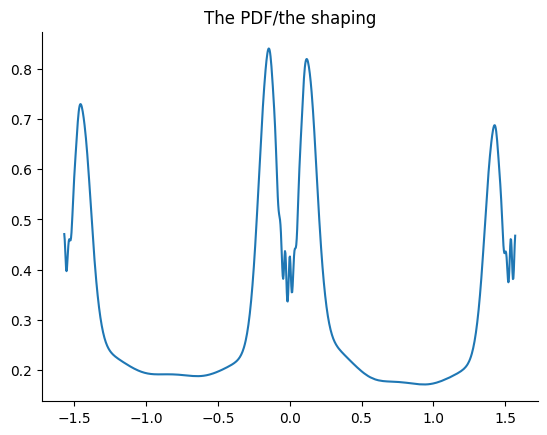

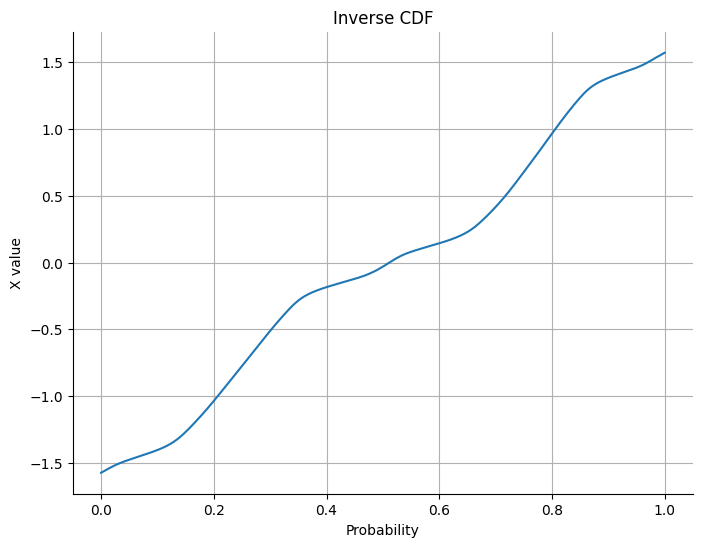

In [3]:
gg, ggpart = load_online(name='peter',twowm=True,delay=False)

allresp = np.where(np.deg2rad(gg['allResponse']) > np.pi/2, np.deg2rad(gg['allResponse'])-np.pi, np.deg2rad(gg['allResponse']))
allresp = np.where(allresp < -np.pi/2, allresp+np.pi, allresp)
allstim = np.where(np.deg2rad(gg['allTarget']) > np.pi/2, np.deg2rad(gg['allTarget'])-np.pi, np.deg2rad(gg['allTarget']))
allstim = np.where(allstim < -np.pi/2, allstim+np.pi, allstim)

with open('data/gam/uniform_model_base_inv_kappa_free.pkl', 'rb') as file:
    other_data = pickle.load(file)

unif_map = usu.UnifMap(data=other_data)
unif_map.get_cdf_and_inverse_cdf()

allresp_uni = unif_map.angle_space_to_unif_space(allresp)
allstim_uni = unif_map.angle_space_to_unif_space(allstim)

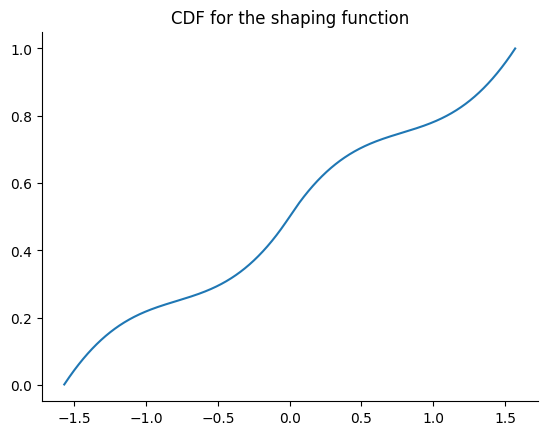

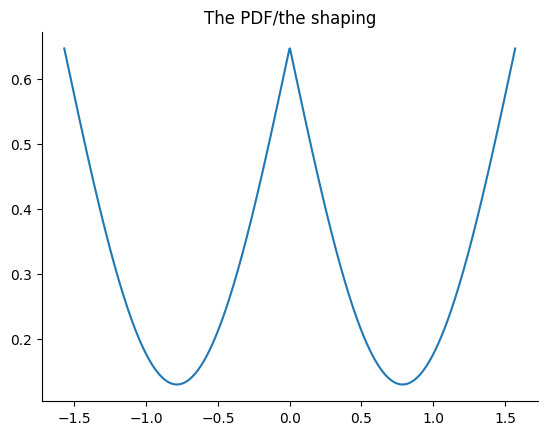

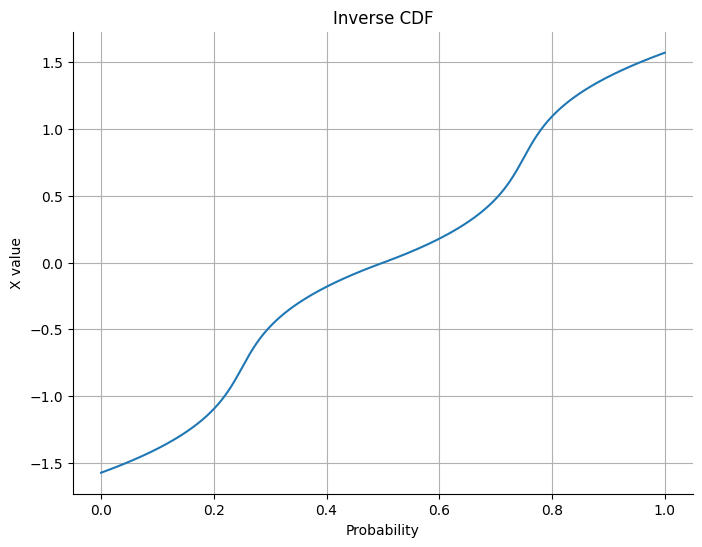

In [4]:
with open('data/gam/uniform_function_cardinal.obj', 'rb') as f:
    card = pickle.load(f)
    
card_map = usu.UnifMap(data=card)
card_map.get_cdf_and_inverse_cdf()

allresp_card = card_map.angle_space_to_unif_space(allresp)
allstim_card = card_map.angle_space_to_unif_space(allstim)

In [5]:
def combine_von_mises(mu1, kappa1, mu2, kappa2):
    """
    Combine two von Mises distributions VM(mu1, kappa1) and VM(mu2, kappa2)
    into a single von Mises distribution.
    
    Parameters:
        mu1 (float): mean of the first von Mises (in radians)
        kappa1 (float): concentration of the first von Mises
        mu2 (float): mean of the second von Mises (in radians)
        kappa2 (float): concentration of the second von Mises

    Returns:
        mu_comb (float): mean of the combined von Mises (in radians)
        kappa_comb (float): concentration of the combined von Mises
    """
    x = kappa1 * np.cos(2 * mu1) + kappa2 * np.cos(2 * mu2)
    y = kappa1 * np.sin(2 * mu1) + kappa2 * np.sin(2 * mu2)

    mu_comb = 0.5 * np.arctan2(y, x)
    kappa_comb = np.hypot(x, y)  # sqrt(x^2 + y^2)

    return (mu_comb + np.pi / 2) % (np.pi) - np.pi / 2, kappa_comb


In [6]:
def angle_diff(a, b):
    """Return the minimal signed difference between two angles (radians)"""
    return ((a - b + np.pi/2) % np.pi) - np.pi/2

def combine_von_mises_orientation(mu1, kappa1, mu2, kappa2):
    """Combine two von Mises cues assuming common source"""
    x = kappa1 * np.cos(2 * mu1) + kappa2 * np.cos(2 * mu2)
    y = kappa1 * np.sin(2 * mu1) + kappa2 * np.sin(2 * mu2)
    mu_comb = 0.5 * np.arctan2(y, x)
    kappa_comb = np.hypot(x, y)
    mu_comb = (mu_comb + np.pi/2) % np.pi - np.pi/2
    return mu_comb, kappa_comb

def causal_inference_orientation(mu1, kappa1, mu2, kappa2, 
    p_common=0.7, sigma_disparity=np.pi/2,sample=True):
    """
    Forward model for causal inference on orientation cues.
    Returns either a sample or the expected final mean.
    """
    delta = angle_diff(mu1, mu2)
    p_likelihood_C1 = np.exp(-0.5 * (delta / sigma_disparity)**2)
    pC1_given_data = (p_likelihood_C1 * p_common) / (p_likelihood_C1 * p_common + (1 - p_common))

    # Step 4: sample causal structure
    if sample:
        C = np.random.rand() < pC1_given_data
    else:
        C = pC1_given_data > 0.5

    # Step 5: estimate
    if C:
        mu_final, _ = combine_von_mises_orientation(mu1, kappa1, mu2, kappa2)
    else:
        # Pick the more reliable cue
        mu_final = np.random.normal(loc=mu1, scale=0.1) if kappa1 > kappa2 else np.random.normal(loc=mu2, scale=0.1)

    return mu_final, pC1_given_data

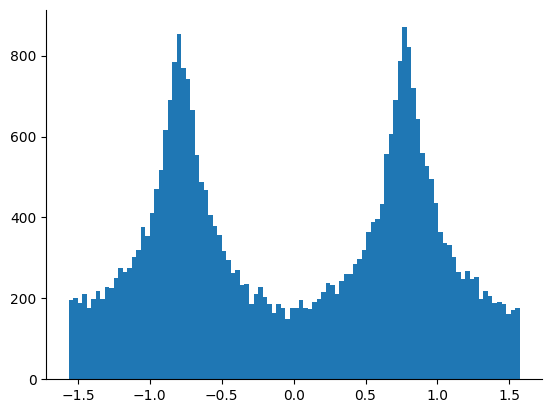

100%|██████████| 34399/34399 [00:00<00:00, 162275.58it/s]


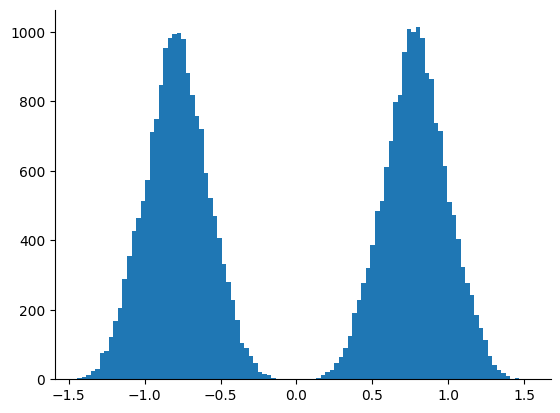

In [7]:
samps = np.random.permutation(allstim_card)
resps = np.zeros(len(samps))
resps[0] = samps[0]

kappa_r = 50
kappa_s = 50

plt.hist(samps,bins=100)
plt.show()

for i in tqdm(range(1, len(samps))):
    # noise = np.random.normal(loc=resps[i-1], scale=0.05)
    if np.abs(samps[i]) < 0.05:
        resps[i], kappa = combine_von_mises(samps[i], kappa_s, resps[i-1], kappa_r)
    elif np.abs(np.abs(samps[i]) - np.pi/2) < 0.05:
        resps[i], kappa = combine_von_mises(samps[i], kappa_s, resps[i-1], kappa_r)
    elif np.abs(np.sign(resps[i-1]) - np.sign(samps[i])) == 0:
        resps[i], kappa = combine_von_mises(samps[i], kappa_s, resps[i-1], kappa_r)
    # elif np.abs(np.sign(resps[i-1]) - np.sign(samps[i])) == 1: #np.abs((resps[i-1] - samps[i] +np.pi/2) % np.pi - np.pi) < 0.01:
    #     print(resps[i-1],samps[i])
    #     resps[i], kappa = combine_von_mises(samps[i], kappa_r, resps[i-1], kappa_s)
    elif np.sign(samps[i]) == 0:
        resps[i], kappa = combine_von_mises(samps[i], kappa_s, samps[i], kappa_r)
    else:
        resps[i], kappa = combine_von_mises(samps[i], kappa_s, -resps[i-1], kappa_r)
    
    #resps[i] = samps[i] + lookup_hist_value(noise,samps[i]) + np.random.normal(loc=0, scale=0.01)
    # unif_lookup = unif_map.angle_space_to_unif_space(lookup)
    # resps[i] = unif_map.unif_space_to_angle_space(np.random.normal(loc=unif_lookup, scale=0.1))

samps = np.where(samps > np.pi/2, samps - np.pi, samps)
samps = np.where(samps < -np.pi/2, samps + np.pi, samps)
resps = np.where(resps > np.pi/2, resps - np.pi, resps)
resps = np.where(resps < -np.pi/2, resps + np.pi, resps)

resps_ang = card_map.unif_space_to_angle_space(resps)
samps_ang = card_map.unif_space_to_angle_space(samps)

plt.hist(resps,bins=100)
plt.show()

/Users/kirawr/Code/psychophysics/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kirawr/Code/psychophysics/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


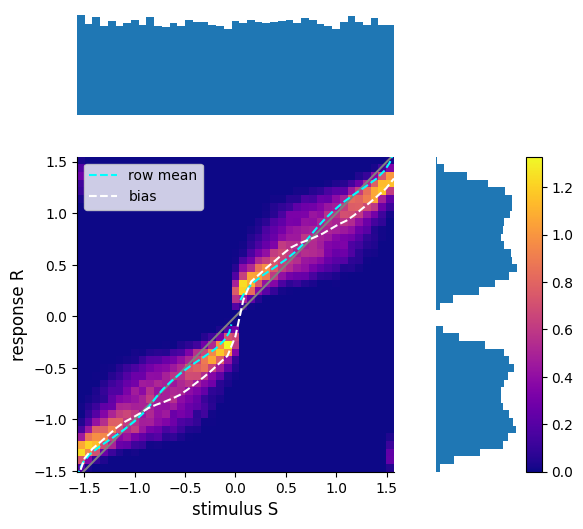

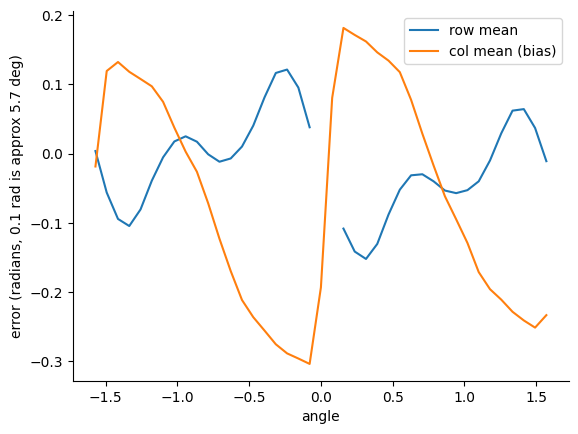

In [8]:
model_plot(samps_ang,resps_ang,binsize=41, plot_lines=True)

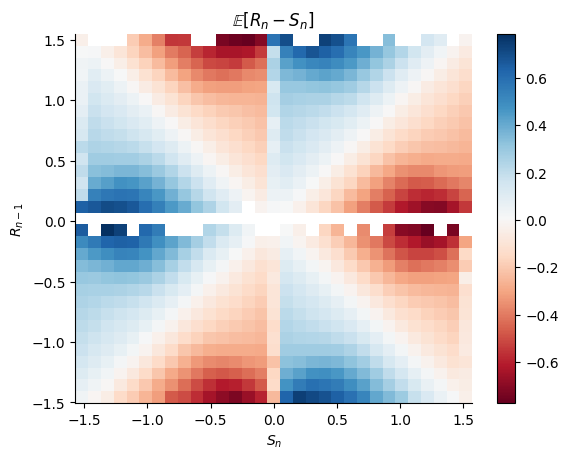

In [9]:
# histogram coloured by rn-sn...
binning = 31

diff1 = resps_ang[1:]-samps_ang[1:]
diff1 = np.where(diff1 > np.pi/2, diff1-np.pi, diff1)
diff1 = np.where(diff1 < -np.pi/2, diff1+np.pi, diff1)

diff = diff1

H, xedges, yedges, binnumber = binned_statistic_2d(samps_ang[1:], resps_ang[:-1], values=diff, 
                                            statistic='mean', bins=binning, expand_binnumbers=True)
H = np.ma.masked_where(H==0, H)
XX, YY = np.meshgrid(xedges, yedges)

plt.pcolormesh(XX,YY,H.T,cmap='RdBu')#,vmin=-0.4,vmax=0.4)
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[(R_{n-1} - R_n)_w + (R_{n}-S_n)_w]$')
plt.title('$\mathbb{E}[R_{n}-S_{n}]$')
plt.show()

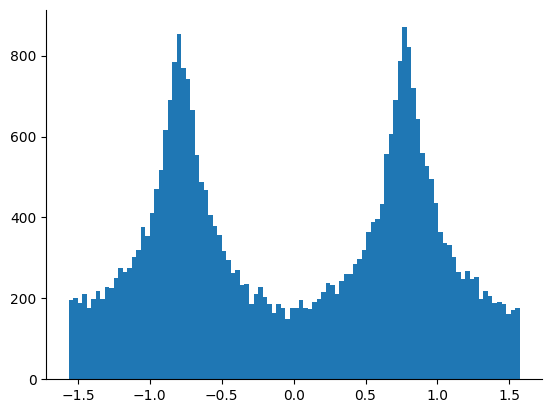

100%|██████████| 34399/34399 [00:00<00:00, 52053.37it/s]


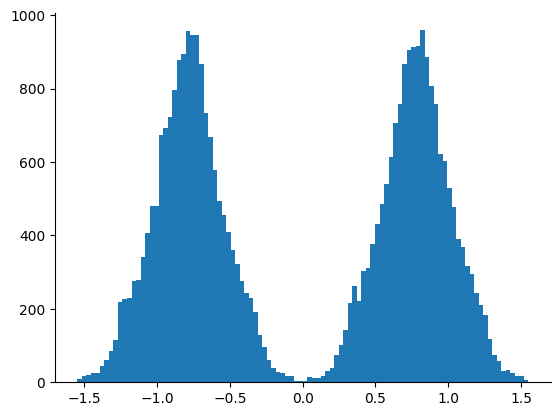

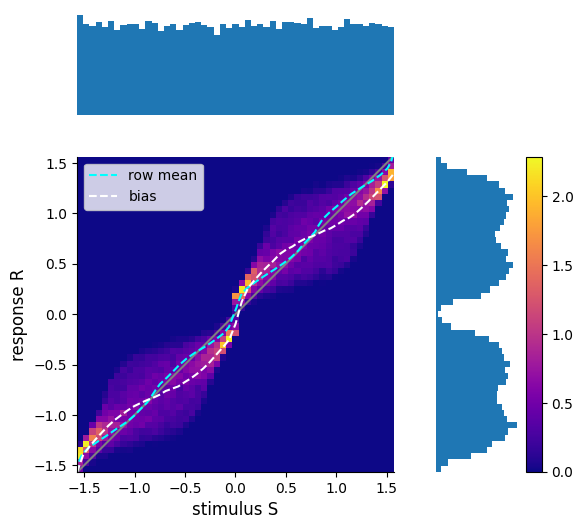

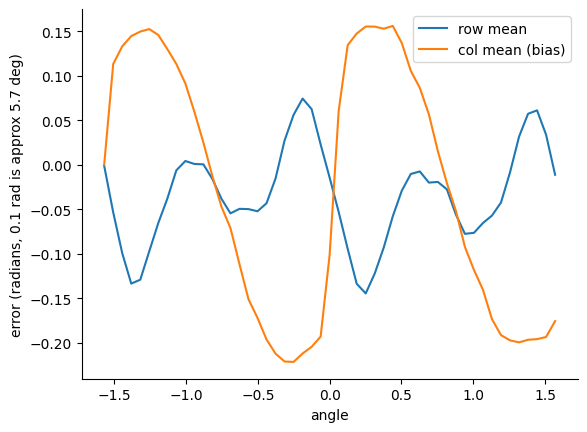

In [27]:
samps = np.random.permutation(allstim_card)
resps = np.zeros(len(samps))
resps[0] = samps[0]

kappa_r = 20
kappa_s = 20
p_common = 0.9

plt.hist(samps,bins=100)
plt.show()

vm_ci = VonMisesCausalInference()

for i in tqdm(range(1, len(samps))):
    # noise = np.random.normal(loc=resps[i-1], scale=0.05)
    if np.abs(np.sign(resps[i-1]) - np.sign(samps[i])) == 0:
        #resps[i], kappa = causal_inference_orientation(samps[i], kappa_s, resps[i-1], kappa_r, p_common=0.01)
        resps[i] = vm_ci.bayesian_causal_inference(samps[i], resps[i-1], kappa_s, kappa_r,
                                                    mu_p=None, sigma_p=None, pi_c = p_common)[0]
    else:
        #resps[i], kappa = causal_inference_orientation(samps[i], kappa_s, -resps[i-1], kappa_r, p_common=0.01 )
        resps[i] = vm_ci.bayesian_causal_inference(samps[i], -resps[i-1], kappa_s, kappa_r,
                                                    mu_p=None, sigma_p=None, pi_c = p_common)[0]
    #resps[i] = samps[i] + lookup_hist_value(noise,samps[i]) + np.random.normal(loc=0, scale=0.01)
    # unif_lookup = unif_map.angle_space_to_unif_space(lookup)
    # resps[i] = np.random.vonmises(mu=samps[i], kappa=20)

samps = np.where(samps > np.pi/2, samps - np.pi, samps)
samps = np.where(samps < -np.pi/2, samps + np.pi, samps)
resps = np.where(resps > np.pi/2, resps - np.pi, resps)
resps = np.where(resps < -np.pi/2, resps + np.pi, resps)

resps_ang = card_map.unif_space_to_angle_space(resps)
samps_ang = card_map.unif_space_to_angle_space(samps)

plt.hist(resps,bins=100)
plt.show()

model_plot(samps_ang,resps_ang,binsize=51, plot_lines=True)

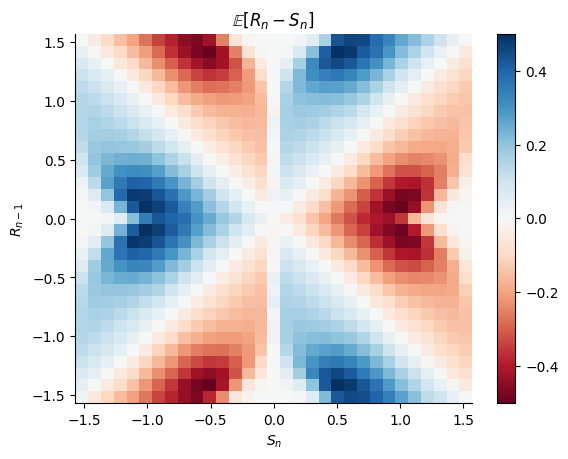

In [11]:
binning = 31

diff1 = resps_ang[1:]-samps_ang[1:]
diff1 = np.where(diff1 > np.pi/2, diff1-np.pi, diff1)
diff1 = np.where(diff1 < -np.pi/2, diff1+np.pi, diff1)

diff = diff1

H, xedges, yedges, binnumber = binned_statistic_2d(samps_ang[1:], resps_ang[:-1], values=diff, 
                                            statistic='mean', bins=binning, expand_binnumbers=True)
H = np.ma.masked_where(H==0, H)
XX, YY = np.meshgrid(xedges, yedges)

plt.pcolormesh(XX,YY,H.T,cmap='RdBu')#,vmin=-0.4,vmax=0.4)
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[(R_{n-1} - R_n)_w + (R_{n}-S_n)_w]$')
plt.title('$\mathbb{E}[R_{n}-S_{n}]$')
plt.show()

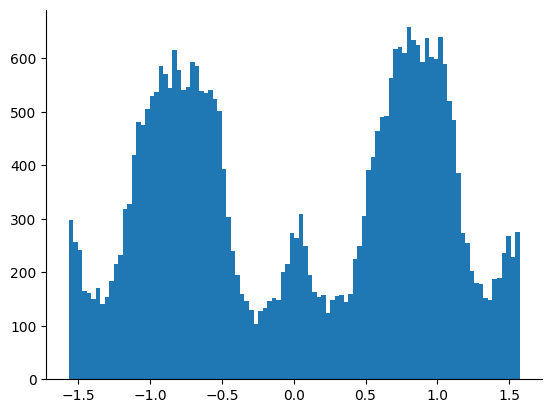

100%|██████████| 34399/34399 [00:00<00:00, 42030.43it/s]


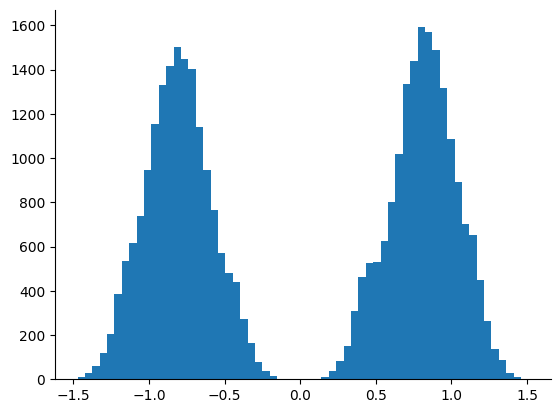

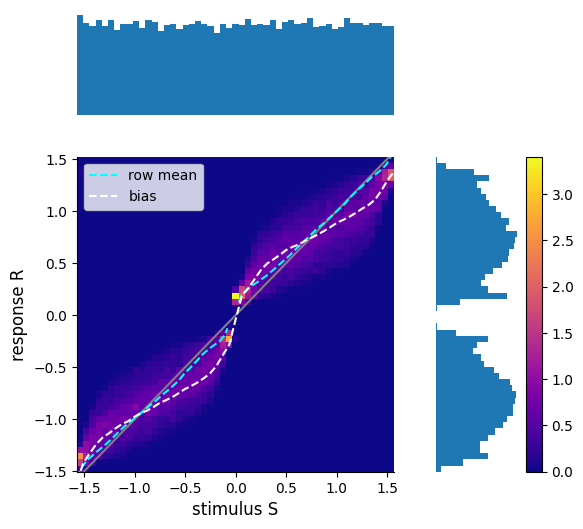

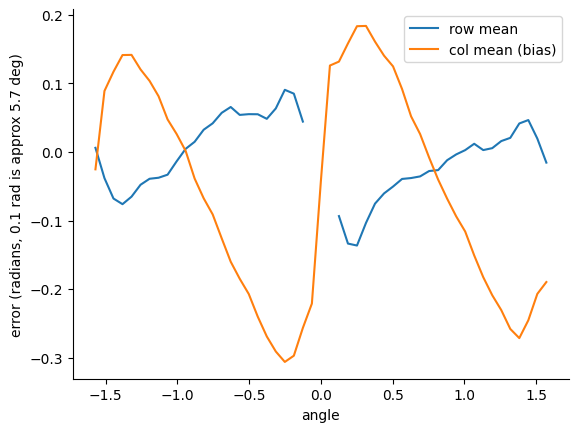

In [31]:
samps = np.random.permutation(allstim_uni)
resps = np.zeros(len(samps))
resps[0] = samps[0]

kappa_r = 10
kappa_s = 10
p_common = 0.9

plt.hist(samps,bins=100)
plt.show()

vm_ci = VonMisesCausalInference()

for i in tqdm(range(1, len(samps))):
    # noise = np.random.normal(loc=resps[i-1], scale=0.05)
    if np.abs(np.sign(resps[i-1]) - np.sign(samps[i])) == 0:
        resps[i], kappa = causal_inference_orientation(samps[i], kappa_s, resps[i-1], kappa_r, p_common=0.9)
        resps[i] = vm_ci.bayesian_causal_inference(samps[i], resps[i-1], kappa_s, kappa_r,
                                                    mu_p=None, sigma_p=None, pi_c = p_common)[0]
    else:
        resps[i], kappa = causal_inference_orientation(samps[i], kappa_s, -resps[i-1], kappa_r, p_common=0.9 )
        resps[i] = vm_ci.bayesian_causal_inference(samps[i], -resps[i-1], kappa_s, kappa_r,
                                                    mu_p=None, sigma_p=None, pi_c = p_common)[0]
    #resps[i] = samps[i] + lookup_hist_value(noise,samps[i]) + np.random.normal(loc=0, scale=0.01)
    # unif_lookup = unif_map.angle_space_to_unif_space(lookup)
    # resps[i] = np.random.vonmises(mu=samps[i], kappa=20)

samps = np.where(samps > np.pi/2, samps - np.pi, samps)
samps = np.where(samps < -np.pi/2, samps + np.pi, samps)
resps = np.where(resps > np.pi/2, resps - np.pi, resps)
resps = np.where(resps < -np.pi/2, resps + np.pi, resps)

resps_ang = unif_map.unif_space_to_angle_space(resps)
samps_ang = unif_map.unif_space_to_angle_space(samps)

plt.hist(resps,bins=61)
plt.show()

model_plot(samps_ang,resps_ang,binsize=51, plot_lines=True)

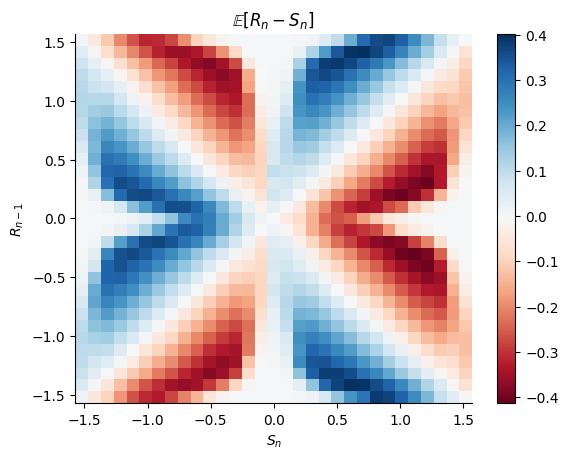

In [13]:
binning = 31

diff1 = resps_ang[1:]-samps_ang[1:]
diff1 = np.where(diff1 > np.pi/2, diff1-np.pi, diff1)
diff1 = np.where(diff1 < -np.pi/2, diff1+np.pi, diff1)

diff = diff1

H, xedges, yedges, binnumber = binned_statistic_2d(samps_ang[1:], resps_ang[:-1], values=diff, 
                                            statistic='mean', bins=binning, expand_binnumbers=True)
H = np.ma.masked_where(H==0, H)
XX, YY = np.meshgrid(xedges, yedges)

plt.pcolormesh(XX,YY,H.T,cmap='RdBu')#,vmin=-0.4,vmax=0.4)
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[(R_{n-1} - R_n)_w + (R_{n}-S_n)_w]$')
plt.title('$\mathbb{E}[R_{n}-S_{n}]$')
plt.show()